## 1. Libraries & Importing Dataset

In [1]:
import polars as pl
import pandas as pd
import unicodedata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder , TargetEncoder , RobustScaler , LabelEncoder , StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Define the input CSV file and create a DataFrame
csv = 'input.csv'
df_csv = pl.read_csv(csv)

## 2. Data Exploration

In [2]:
# Get the shape of dataframe
print(df_csv.shape)

(1433, 63)


In [3]:
# Get insights into Statistics
df_csv.describe()

statistic,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?_duplicated_0,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you s

In [4]:
# Overview of entries
df_csv.glimpse(max_items_per_column=10)

Rows: 1433
Columns: 63
$ Are you self-employed?                             <i64> 0, 0, 0, 1, 0, 0, 0, 0, 0, 1
$ How many employees does your company or organizat… <str> '26-100', '6-25', '6-25', None, '6-25', 'More than 1000', '26-100', 'More than 1000', '26-100', None
$ Is your employer primarily a tech company/organiz… <i64> 1, 1, 1, None, 0, 1, 1, 1, 0, None
$ Is your primary role within your company related … <i64> None, None, None, None, 1, None, None, None, 1, None
$ Does your employer provide mental health benefits… <str> 'Not eligible for coverage / N/A', 'No', 'No', None, 'Yes', 'Yes', "I don't know", 'Yes', "I don't know", None
$ Do you know the options for mental health care av… <str> 'N/A', 'Yes', 'N/A', None, 'Yes', 'I am not sure', 'No', 'Yes', 'No', None
$ Has your employer ever formally discussed mental … <str> 'No', 'Yes', 'No', None, 'No', 'No', 'No', 'No', 'No', None
$ Does your employer offer resources to learn more … <str> 'No', 'Yes', 'No', None, 'No', 'Yes', 'No

## 3. Unicode Normalization

In [5]:
string_df = df_csv.select(pl.col(pl.String))

df_normalized = df_csv.with_columns(
    df_csv.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFD" , str(x)) , return_dtype=pl.String))
)

df = df_normalized.with_columns(
    df_normalized.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFC" , str(x)) , return_dtype=pl.String))
)

## 4. Renaming Columns

In [6]:
# Create a list of all column names to preserve the originals for later
col_names = df.columns

# Dictionary to rename columns
new_names = { "Are you self-employed?" : "self-employed_indic" ,
             "How many employees does your company or organization have?" : "comp_size" ,
             "Is your employer primarily a tech company/organization?" : "tech_comp_indic" ,
             "Is your primary role within your company related to tech/IT?" : "tech_role_indic",
             "Does your employer provide mental health benefits as part of healthcare coverage?" : "availability_of_benefits" ,
             "Do you know the options for mental health care available under your employer-provided coverage?" : "awareness_of_benefits" , 
             "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?" : "mh_discussion_indic" ,
             "Does your employer offer resources to learn more about mental health concerns and options for seeking help?" : "mh_resources_availability_indic" ,
             "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?" : "anonym_use_benefit_indic" ,
             "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:" : "sick_leave_difficulty" ,
             "Do you think that discussing a mental health disorder with your employer would have negative consequences?" : "neg_consequences_discussing_mh" ,
             "Do you think that discussing a physical health issue with your employer would have negative consequences?" : "neg_consequences_discussing_ph" ,
             "Would you feel comfortable discussing a mental health disorder with your coworkers?" : "comf_discussing_mh_with_coworker_indic" ,
             "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_indic" ,
             "Do you feel that your employer takes mental health as seriously as physical health?" : "employer_importance_mh_vs_ph" ,
             "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?" : "known_neg_consequences_of_mh" ,
             "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?" : "med_coverage_mh_indic" ,
             "Do you know local or online resources to seek help for a mental health disorder?" : "known_mh_sources" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?" : "mention_mh_to_clients" ,
             "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_client_of_mh" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?" : "mention_mh_to_employees" ,
             "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_employee_of_mh" ,
             "Do you believe your productivity is ever affected by a mental health issue?" : "productivity_effect_of_mh" ,
             "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?" : "time_effect_of_mh" ,
             "Do you have previous employers?" : "prev_employers" ,
             "Have your previous employers provided mental health benefits?" : "availability_of_benefits_prev_employer" , 
             "Were you aware of the options for mental health care provided by your previous employers?" : "awareness_of_benefits_prev_employer" ,
             "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?" : "mh_discussion_indic_prev_employer" ,
             "Did your previous employers provide resources to learn more about mental health issues and how to seek help?" : "mh_resources_availability_indic_prev_employer" ,
             "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?" : "anonym_use_benefit_indic_prev_employer" ,
             "Do you think that discussing a mental health disorder with previous employers would have negative consequences?" : "neg_consequences_discussing_mh_prev_employer" , 
             "Do you think that discussing a physical health issue with previous employers would have negative consequences?" : "neg_consequences_discussing_ph_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your previous co-workers?" : "comf_discussing_mh_with_coworker_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_prev_employer" ,
             "Did you feel that your previous employers took mental health as seriously as physical health?" : "employer_importance_mh_vs_ph_prev_employer" ,
             "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?" : "known_neg_consequences_of_mh_prev_employer" ,
             "Would you be willing to bring up a physical health issue with a potential employer in an interview?" : "willing_discuss_ph_in_hiring_interview" ,
             "Why or why not?" : "why_why_not_1" ,
             "Would you bring up a mental health issue with a potential employer in an interview?" : "willing_discuss_mh_in_hiring_interview" ,
             "Why or why not?2" : "why_why_not_2" ,
             "Do you feel that being identified as a person with a mental health issue would hurt your career?" : "percevied_neg_impact_carreer_of_mh" ,
             "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?" : "perceived_neg_impact_coworker_opiniton_of_mh" ,
             "How willing would you be to share with friends and family that you have a mental illness?" : "willingness_to_share_with_friend_family" ,
             "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?" : "neg_response_to_mh" ,
             "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?" : "willingness_to_share_mh_after_observation" ,
             "Do you have a family history of mental illness?" : "mh_family_hist" ,
             "Have you had a mental health disorder in the past?" : "previous_mh" ,
             "Do you currently have a mental health disorder?" : "current_mh" ,
             "If yes, what condition(s) have you been diagnosed with?" :  "diagnosis_name_condition" ,
             "If maybe, what condition(s) do you believe you have?" : "believed_name_condiiton" ,
             "Have you been diagnosed with a mental health condition by a medical professional?" : "diagnosis_professional" ,
             "If so, what condition(s) were you diagnosed with?" : "diagnosis_name_professional_condition" ,
             "Have you ever sought treatment for a mental health issue from a mental health professional?" : "used_therapy" ,
             "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?" : "interference_mh_treated_with_work" ,
             "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?" : "interference_mh_untreated_with_work" ,
             "What is your age?" : "age" ,
             "What is your gender?" : "gender" ,
             "What country do you live in?" : "country_residency" ,
             "What US state or territory do you live in?" : "usa_state_residency" ,
             "What country do you work in?" : "country_work" ,
             "What US state or territory do you work in?" : "usa_state_work" ,
             "Which of the following best describes your work position?" : "job_title" ,
             "Do you work remotely?" : "remote" ,
            }

# Rename the keys in the dictionary with the names of the original DataFrame.
new_names = dict((col_names[list(new_names.keys()).index(key)], value) for key, value in new_names.items())
df = df.rename(new_names).with_row_index("index")

## 5. Handling Self-employed Features

In [7]:
# Drop all columns that are meant for self-employed and filter out the people that are self-employed
df = df.filter(pl.col("self-employed_indic") != 1)
df = df.drop("self-employed_indic")

## 6. Investigating Null values

In [8]:
# Count columns with null values and those without
null_counts = df.null_count()

# Transpose the dataframe to write the amount of null values entriewise
null_counts_trans = null_counts.transpose(include_header= True)
null_counts_trans = null_counts_trans.filter(pl.col('column')!='index')
# Get the number of columns with null values and without
true_null_counts = null_counts_trans.filter(pl.col("column_0") == 0).shape[0]
non_null_counts = null_counts_trans.filter(pl.col("column_0") != 0).shape[0]

# Calculate the percentage of NULL values per column and get the number
null_counts_perc = null_counts_trans.with_columns((pl.col("column_0") / df.shape[0] * 100).cast(pl.Int32).alias("null_perc") )

# Get the number of columns with 0 percent nulls, according to the percentages.
non_null_counts = null_counts_perc.filter(pl.col('null_perc') == 0).shape[0]

[Text(0, 0, '34'), Text(0, 0, '17'), Text(0, 0, '11')]

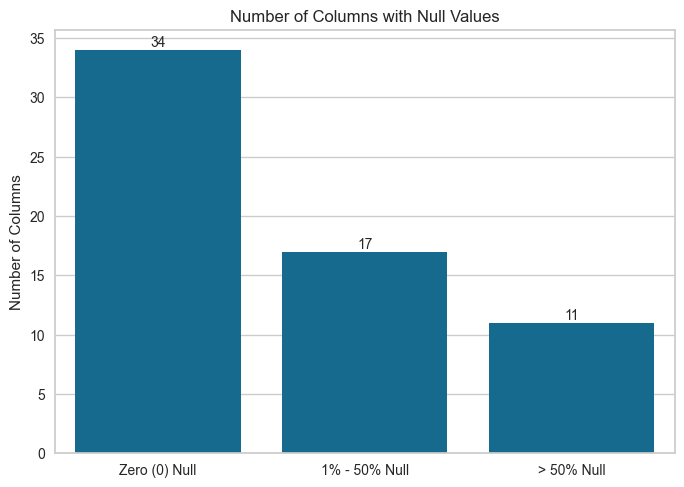

In [9]:
# Construct the number of Columns with exactly 0% null values
num_null_counts_zero_perc = null_counts_perc.filter(pl.col("null_perc") ==0).shape[0]

# Construct the number for columns with less than 50% of null values but more than 0% null values
num_null_counts_below_50_perc = null_counts_perc.filter((pl.col('null_perc') <= 50) & (pl.col('null_perc') > 0)).shape[0]

# Construct the number for columns with more than 50% null values
num_null_counts_exc_50_perc = null_counts_perc.filter(pl.col("null_perc") > 50).shape[0]

# Create a dictionary with the relevant information
nulls_dict = {"Zero (0) Null" : non_null_counts , "1% - 50% Null" : num_null_counts_below_50_perc ,  "> 50% Null" : num_null_counts_exc_50_perc}
# Plot the amount of columns with null values
ax = sns.barplot(data=nulls_dict)
ax.set(xlabel='' , ylabel='Number of Columns')
ax.set_title("Number of Columns with Null Values")
ax.bar_label(ax.containers[0], fontsize=10)

### Null Value Handling

In [10]:
# Look at the columns with more than 50% Null Values
drop_col_list = pl.Series(null_counts_perc.filter(pl.col("null_perc")>50).select(pl.col("column"))).to_list()
print(drop_col_list)

['tech_role_indic', 'med_coverage_mh_indic', 'known_mh_sources', 'mention_mh_to_clients', 'neg_impact_of_reveal_to_client_of_mh', 'mention_mh_to_employees', 'neg_impact_of_reveal_to_employee_of_mh', 'productivity_effect_of_mh', 'time_effect_of_mh', 'diagnosis_name_condition', 'believed_name_condiiton']


#### Standardizing answers of categorical features

In [11]:
# Standardize all categorical columsn that are currently answered with 0/1 instead of yes/no
df = df.with_columns(
    pl.when(pl.col('tech_comp_indic') == 1).then(pl.lit('yes')).when(pl.col('tech_comp_indic') == 0).then(pl.lit('no')).alias('tech_comp_indic') ,
    pl.when(pl.col('tech_role_indic') == 1).then(pl.lit('yes')).when(pl.col('tech_role_indic') == 0).then(pl.lit('no')).alias('tech_role_indic') ,
    pl.when(pl.col('used_therapy') == 1).then(pl.lit('yes')).when(pl.col('used_therapy') == 0).then(pl.lit('no')).alias('used_therapy')          ,                          
    pl.when(pl.col('prev_employers') == 1).then(pl.lit('yes')).when(pl.col('prev_employers') == 0).then(pl.lit('no')).alias('prev_employers')
)

### Imputation of Null Values

In [12]:
# Convert all strings to lower case
df = df.with_columns(pl.col(pl.String).str.to_lowercase())

##### Imputation of feature: 'tech_role_indic'

In [13]:
# Now lets find the list of tech jobs
tech_jobs_list =  df.filter(pl.col("tech_role_indic") == pl.lit('yes')).select("job_title").rows()

# Job list is currently a list nested of tuples
# Define function to flatten nested list
def flatten_list(list_input):
    job_list = []
    for x in list_input:
        job_list.extend(x)
    return job_list

# Clear job_list of any nested tuples and splitters
job_list = flatten_list(tech_jobs_list)
job_list = [x.split('|') for x in job_list]
job_list = flatten_list(job_list)
job_list = [x.split('/') for x in job_list]
job_list = flatten_list(job_list)

# Clear job titles of non-tech jobs
excluded_jobs = ['other' , 'designer' , 'support' , 'team lead' , 'sales' , 'supervisor' , 'advocate' , 'one-person shop' , 'executive leadership', 'hr']
job_list = [x for x in job_list if x not in excluded_jobs]

job_list = np.unique(job_list)

# Now that we have a cleaned list of tech jobs we need to impute the DataFrame
# First we construct a regex pattern to catch all possible values

job_pattern = '|'.join(job_list)

df = df.with_columns(
    pl.when(
        (pl.col('job_title').str.contains(job_pattern)) & (pl.col('tech_role_indic').is_null())
    ).then(pl.lit('yes')).otherwise(pl.lit('no')).alias('tech_role_indic')
)

##### Imputation of feature 'diagnosis_name_condition'

In [14]:
# For this use the followuing method: if col "current_mh" is "no"  or "maybe" then impute it wiht "n/a"
df = df.with_columns(
    pl.when(pl.col('current_mh').is_in(['no' , 'maybe']) , pl.col('diagnosis_name_condition').is_null() ).then(pl.lit('n/a')).otherwise('diagnosis_name_condition').alias('diagnosis_name_condition')
)

##### Imputation of feature 'believed_name_condition'

In [15]:
# For this use the following method: if col "current_mh" is "no" or "yes" then impute it with "n/a"
df = df.with_columns(
    pl.when(pl.col('current_mh').is_in(['no' , 'yes']) , pl.col('believed_name_condiiton').is_null() ).then(pl.lit('n/a')).otherwise('believed_name_condiiton').alias('believed_name_condiiton')
)

##### Imputation of features "country_residency" & "country_work"

In [16]:
df = df.with_columns(
    pl.when(pl.col('country_residency') != 'united states of america').then(pl.lit('international')).otherwise('usa_state_residency').alias('usa_state_residency'),
    pl.when(pl.col('country_work') != 'united states of america').then(pl.lit('international')).otherwise('usa_state_work').alias('usa_state_work')
)

##### Imputation of features relying on feature "prev_employers"

In [17]:
df = df.with_columns(	
    pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('availability_of_benefits_prev_employer')).alias('availability_of_benefits_prev_employer') 
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('awareness_of_benefits_prev_employer')).alias('awareness_of_benefits_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('mh_discussion_indic_prev_employer')).alias('mh_discussion_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('mh_resources_availability_indic_prev_employer')).alias('mh_resources_availability_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('anonym_use_benefit_indic_prev_employer')).alias('anonym_use_benefit_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('neg_consequences_discussing_mh_prev_employer')).alias('neg_consequences_discussing_mh_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('neg_consequences_discussing_ph_prev_employer')).alias('neg_consequences_discussing_ph_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('comf_discussing_mh_with_coworker_prev_employer')).alias('comf_discussing_mh_with_coworker_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('comf_discussing_mnh_with_supervisor_prev_employer')).alias('comf_discussing_mnh_with_supervisor_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('employer_importance_mh_vs_ph_prev_employer')).alias('employer_importance_mh_vs_ph_prev_employer')                    
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('known_neg_consequences_of_mh_prev_employer')).alias('known_neg_consequences_of_mh_prev_employer')                                                        
)

##### Imputation of features "diagnosis_name_condition" & "believed_name_condiiton"

In [18]:
# Imputation of "diagnosis_name_condition"
most_common_diagnosis_name = df.select(pl.col('diagnosis_name_condition')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('diagnosis_name_condition')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('diagnosis_name_condition').is_null()).then(pl.lit(most_common_diagnosis_name)).otherwise('diagnosis_name_condition').alias('diagnosis_name_condition')
)

# Imputation of "believed_name_condiiton"
most_common_believed_name = df.select(pl.col('believed_name_condiiton')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('believed_name_condiiton')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('believed_name_condiiton').is_null()).then(pl.lit(most_common_believed_name)).otherwise('believed_name_condiiton').alias('believed_name_condiiton')
)

##### Imputation of "willingness_to_share_mh_after_observation"

In [19]:
# Investigate how to impute 'willingness_to_share_mh_after_observation' based on 'neg_response_to_mh'
df.select(pl.col(['neg_response_to_mh' ,'willingness_to_share_mh_after_observation' ])).filter((pl.col('neg_response_to_mh') == 'no') | (pl.col('neg_response_to_mh') == 'n/a'))

neg_response_to_mh,willingness_to_share_mh_after_observation
str,str
"""no""",null
"""no""",null
"""no""",null
"""no""",null
"""no""",null
…,…
"""no""",null
"""no""",null
"""no""",null


In [20]:
# Impute the columns 'willingness_to_share_mh_after_observation' with n/a incase 'neg_response_to_mh' was answered with 'no' or 'n/a'
df = df.with_columns(
    pl.when(pl.col('neg_response_to_mh') == 'n/a', pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit('n/a')).otherwise(pl.col('willingness_to_share_mh_after_observation')).alias('willingness_to_share_mh_after_observation')
)
df = df.with_columns(
    pl.when(pl.col('neg_response_to_mh') == 'no', pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit('n/a')).otherwise(pl.col('willingness_to_share_mh_after_observation')).alias('willingness_to_share_mh_after_observation')
)

##### Imputation & Standardization of feature 'gender'

In [21]:
# Strip entries of whitespace
df = df.with_columns(
    pl.col('gender').str.strip_chars().alias('gender')
)
# Standardize male
df = df.with_columns(
    pl.col('gender').replace(['m' ,  'male.' , 'cis male' , 'male (cis)' , 'man' , 'dude' , 'cis man' , 'sex is male' , 'mail' , 'cisdude'], 'male').alias('gender')
)
# Standardize female
df = df.with_columns(
    pl.col('gender').replace(['f' ,  'i identify as female.' , 'cis female' , 'female assigned at birth' , 'female/woman' , 'woman' , 'fm' , 'fem' , 'cisgender female' , 'cis-woman' 
                              ,'female (props for making this a freeform field, though)'], 'female').alias('gender')
)
# Standardize others
df = df.with_columns(
    pl.when(pl.col('gender').is_in(['male' , 'female']).not_()).then(pl.lit('other')).otherwise(pl.col('gender')).alias('gender')
)
# Impute missing gender values with the most common gender
most_common_gender = df.select(pl.col('gender')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('gender')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('gender').is_null()).then(pl.lit(most_common_gender)).otherwise('gender').alias('gender')
)

##### Imputation of feature 'diagnosis_name_professional_condition'

In [22]:
# Impute the null values of the feature 'diagnosis_name_professional_condition' , if there is no diagnosis in feature 'diagnosis_professional'
df = df.with_columns(
    pl.when(pl.col('diagnosis_professional') == 'no').then(pl.lit('n/a')).otherwise('diagnosis_name_professional_condition').alias('diagnosis_name_professional_condition')
)
# Find the name of the most common diagnosis
most_common_mh_diagnosis = df.select(pl.col('diagnosis_name_professional_condition')).to_series().value_counts().sort(by='count' , descending=True).to_series()[1]
# Impute the missing values with the most common diagnosis
df = df.with_columns(
    pl.when(pl.col('diagnosis_name_professional_condition').is_null()).then(pl.lit(most_common_mh_diagnosis)).otherwise('diagnosis_name_professional_condition').alias('diagnosis_name_professional_condition')
)

##### Imputation of feature 'willingness_to_share_mh_after_observation'

In [23]:
# Find the name of the most common answer
most_common_willingness = df.select(pl.col('willingness_to_share_mh_after_observation')).to_series().value_counts().sort(by='count' , descending=True).to_series()[1]
# Impute the missing values with the most common answer to 'willingness_to_share_mh_after_observation'
df = df.with_columns(
    pl.when(pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit(most_common_willingness)).otherwise('willingness_to_share_mh_after_observation').alias('willingness_to_share_mh_after_observation')
)

##### Drop columns with too many NULL values

In [24]:
# Reconstruct the columns with too many null values
null_counts = df.null_count().transpose(include_header= True)
null_counts_perc = null_counts.with_columns((pl.col("column_0") / df.shape[0] * 100).cast(pl.Int32).alias("null_perc") )
drop_col_list = pl.Series(null_counts_perc.filter(pl.col("null_perc")>50).select(pl.col("column"))).to_list()

print(drop_col_list)

['med_coverage_mh_indic', 'known_mh_sources', 'mention_mh_to_clients', 'neg_impact_of_reveal_to_client_of_mh', 'mention_mh_to_employees', 'neg_impact_of_reveal_to_employee_of_mh', 'productivity_effect_of_mh', 'time_effect_of_mh']


In [25]:
# Drop the columns with more than 50% null values
df = df.drop(drop_col_list)

##### Investigate shape of new DataFrame

In [26]:
print(df.shape)

(1146, 55)


##### Investigate the remaining columns with null values and impute them if necessary or possible

In [27]:
df.null_count().transpose(include_header= True).filter(pl.col('column_0') > 0)

column,column_0
str,u32
"""why_why_not_1""",274
"""why_why_not_2""",249


## 7. Create 2 new Target Variables to apply feature selection methods to

#### Generate feature of people that have the feeling their mental health issue can interfering with their work

In [28]:
# Generate feature about the interference of MH issue with work 
df = df.with_columns(
    pl.when( (pl.col('interference_mh_treated_with_work').is_in(['not applicable to me' , 'never']).not_() ) | (pl.col('interference_mh_untreated_with_work').is_in(['not applicable to me' , 'never']).not_()) ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('inter_all')
)

In [29]:
# Generate feature about the suspicion of negative consequences for being honest about MH issue
df = df.with_columns(
    pl.when( (pl.col('neg_consequences_discussing_mh').is_in(['yes' , 'maybe']))  |  (pl.col('perceived_neg_impact_coworker_opiniton_of_mh').is_in(['yes, i think they would' , 'yes, they do' , 'maybe'])) ).then(pl.lit('1')).otherwise(pl.lit('0')).alias('suspicion_neg_consequences') 
)

## 8. Investigate feature type by value_counts

In [30]:
df.select(pl.all().n_unique())

index,comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,why_why_not_1,willing_discuss_mh_in_hiring_interview,why_why_not_2,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_condition,believed_name_condiiton,diagnosis_professional,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,age,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote,inter_all,suspicion_neg_consequences
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1146,6,2,2,4,4,3,3,3,6,3,3,3,3,3,2,2,5,5,5,4,5,5,4,4,5,5,4,3,863,3,854,5,5,6,5,4,3,3,3,102,78,2,90,2,5,5,51,3,43,48,44,49,180,3,2,2


### Categorize the Features by their type

In [31]:
# Manually categorize ordinal and nominal features
feat_cat_ordinal = ['comp_size' , 'sick_leave_difficulty' , 'availability_of_benefits' , 'availability_of_benefits_prev_employer' ,  'awareness_of_benefits_prev_employer' , 'mh_discussion_indic_prev_employer' 
                    , 'mh_resources_availability_indic_prev_employer' , 'anonym_use_benefit_indic_prev_employer' , 'neg_consequences_discussing_mh_prev_employer'
                    , 'neg_consequences_discussing_ph_prev_employer' , 'comf_discussing_mh_with_coworker_prev_employer' , 'comf_discussing_mnh_with_supervisor_prev_employer'
                    , 'employer_importance_mh_vs_ph_prev_employer' , 'known_neg_consequences_of_mh_prev_employer', 'percevied_neg_impact_carreer_of_mh' , 
                    'perceived_neg_impact_coworker_opiniton_of_mh' ,'willingness_to_share_with_friend_family' , 'interference_mh_treated_with_work'
                    , 'interference_mh_untreated_with_work' , 'remote']
feat_cat_nominal = ['tech_comp_indic' , 'tech_role_indic' , 'awareness_of_benefits' , 'mh_discussion_indic' , 'mh_resources_availability_indic' 
                    , 'anonym_use_benefit_indic' , 'neg_consequences_discussing_mh' , 'neg_consequences_discussing_ph' , 'comf_discussing_mh_with_coworker_indic' , 'comf_discussing_mnh_with_supervisor_indic' 
                    , 'employer_importance_mh_vs_ph' ,'known_neg_consequences_of_mh' , 'prev_employers'  , 'willing_discuss_ph_in_hiring_interview'
                    , 'willing_discuss_mh_in_hiring_interview' ,  'neg_response_to_mh' , 
                    'willingness_to_share_mh_after_observation' , 'mh_family_hist' , 'previous_mh' , 'current_mh'  , 'used_therapy'  , 'gender' , 'country_residency'
                    , 'usa_state_residency' , 'country_work' , 'usa_state_work' , 'job_title' , 'diagnosis_name_professional_condition' , 'diagnosis_name_condition' , 'age' , 'diagnosis_professional' , 'believed_name_condiiton'
                   , 'inter_all' , 'suspicion_neg_consequences']


feat_target_variable = []

# This variable can be filled later dynamically
feat_text = []

In [32]:
# Fill the feat_text list with the remaining features
# get a list of all columns to compare to
column_list = df.columns

# Define function to check if entries are missing
def fill_feat_text():
    for x in column_list:
        if x not in feat_cat_ordinal and x not in feat_cat_nominal and x not in feat_target_variable and x not in feat_text:
            feat_text.append(x)
        else:
            continue
fill_feat_text()

# remove the index feature
feat_text.remove('index')

## Feature Encoding

In [33]:
# Create a DataFrame for the Target encoding
df_targ = df.drop(feat_text)
df_targ = df_targ.drop('index') 

#### Ordinal Encoding for the whole dataset

In [34]:
# First encode the Ordinal features via ordinalencoder
enc = OrdinalEncoder(categories=[
    ['1-5','6-25','26-100','100-500','500-1000','more than 1000'] ,
    ["i don't know",'very easy','somewhat easy','neither easy nor difficult','somewhat difficult','very difficult'] , 
    ['not eligible for coverage / n/a',"i don't know",'yes','no'] ,
    ['not applicable' , "i don't know" , "yes, they all did" , "some did","no, none did"] , 
    ["not applicable","yes, i was aware of all of them","i was aware of some","no, i only became aware later","n/a (not currently aware)"] , 
    ["not applicable","i don't know","yes, they all did","some did","none did"] , 
    ["not applicable","yes, they all did","some did","none did"]  ,
    ["not applicable", "i don't know" ,"yes, always" ,"sometimes" ,"no"] , 
    ["not applicable","i don't know","yes, all of them","some of them","none of them"] , 
    ["not applicable","yes, all of them","some of them","none of them"] , 
    ["not applicable","yes, at all of my previous employers","some of my previous employers","no, at none of my previous employers"] , 
    ["not applicable","i don't know","yes, at all of my previous employers","some of my previous employers","no, at none of my previous employers"] ,
    ["not applicable","i don't know","yes, they all did","some did","none did"] ,
    ["not applicable","yes, all of them","some of them","none of them"] ,
    ["yes, it has","yes, i think it would","maybe","no, i don't think it would","no, it has not"] , 
    ["yes, they do","yes, i think they would","maybe","no, i don't think they would","no, they do not"] ,
    ["not applicable to me (i do not have a mental illness)","very open","somewhat open","neutral","somewhat not open","not open at all"] , 
    ["not applicable to me","often","sometimes","rarely","never"] ,
    ["not applicable to me","often","sometimes","rarely","never"] , 
    ["always","sometimes","never"]
                                ]
)

In [35]:
# Create a ordered list of column names of ordinal features
ord_columns = df.select(pl.col(feat_cat_ordinal)).columns
# fit and transform the ordinal featrues to the OrdinalTransformation
ordinal_transformation = enc.fit_transform(df.select(pl.col(feat_cat_ordinal)))
# Create a dataframe of the transformed features
df_ordinal_transformation = pl.DataFrame(ordinal_transformation, schema = ord_columns)

# replace the original columns with the transformed ones:
df = df.with_columns(df_ordinal_transformation)

#### Label Encoding for the whole data set (Path 1)

In [36]:
enc_label = LabelEncoder()

label_mappings = {}

for x in feat_cat_nominal:
    df = df.with_columns(pl.Series(x , enc_label.fit_transform(df[x].to_numpy())))
    label_mappings[x] = dict(zip(enc_label.classes_, range(len(enc_label.classes_))))

#### TargetEncoder for the 2 new Target Variables: 'inter_all' & 'suspicion_neg_consequences' (Path 2)

In [37]:
# From here on we use the dataframe: df_targ

# First Target Variable 1: 'inter_all'
# Invoke TargetEncoder Class
enc_auto = TargetEncoder(smooth="auto")
# Fit the TargetEncoder and Transform the nominal features based on the target variable
X_trans_t1 = enc_auto.fit_transform(df_targ.drop('inter_all').to_numpy(), df_targ.select(pl.col('inter_all')).to_numpy().ravel())

# construct a dataframe out of the transformed features
columns_df_t1 = df_targ.drop('inter_all').columns
df_targ_1 = pl.DataFrame(X_trans_t1 , schema=columns_df_t1)
df_targ_1 = df_targ_1.with_columns(
    df_targ.select(pl.col('inter_all'))
)


# First Target Variable 1: 'suspicion_neg_consequences'
X_trans_t2 = enc_auto.fit_transform(df_targ.drop('suspicion_neg_consequences').to_numpy(), df_targ.select(pl.col('suspicion_neg_consequences')).to_numpy().ravel())

# construct a dataframe out of the transformed features
columns_df_t2 = df_targ.drop('suspicion_neg_consequences').columns
df_targ_2 = pl.DataFrame(X_trans_t2 , schema=columns_df_t2)
df_targ_2 = df_targ_2.with_columns(
    df_targ.select(pl.col('suspicion_neg_consequences'))
)

## Feature Scaling (Path 1)

In [38]:
# create feature df_scale
df_scale = df.drop(['index' , 'why_why_not_1' , 'why_why_not_2'])

In [39]:
# StandardScaler
transformer = StandardScaler().fit(df_scale)
transformer

StandardScaler()

In [40]:
trans_arr = transformer.transform(df_scale)
# Extract the columns of the DataFrame
df_scale_columns = df_scale.columns

# Re-Construct the DataFrame with the scaled information
df_scaled = pl.DataFrame(trans_arr , schema=df_scale_columns)

## Feature Scaling for Target Variable 1 & Target Variable 2 (Path 2)

In [41]:
# Fit the RobusScaler to TARGET VARIABLE 1
trans_tv_df = RobustScaler().fit_transform(df_targ_1)
# Extract the columns of the DataFrame
df_scale_tv_columns = df_scale.columns
# Re-Construct the DataFrame with the scaled information
df_targ_1 = pl.DataFrame(trans_tv_df , schema=df_scale_tv_columns)



# Fit the RobusScaler to TARGET VARIABLE 2
trans_tv_df = RobustScaler().fit_transform(df_targ_2)
# Extract the columns of the DataFrame
df_scale_tv_columns = df_scale.columns
# Re-Construct the DataFrame with the scaled information
df_targ_2 = pl.DataFrame(trans_tv_df , schema=df_scale_tv_columns)

##### Construct 2 different dataframes:
    - df_target_var_1
    - df_target_var_2

In [42]:
# create feature df_target_variable_var_1
df_target_variable_var_1 = df_targ_1.drop(['inter_all'])
# df_target_variable_var_2
df_target_variable_var_2 = df_targ_2.drop(['suspicion_neg_consequences'])

## 13. Feature Selection (Path 2)

##### ANOVA - target variable 1

In [43]:
# Get the feature names
feature_names = df_target_variable_var_1.columns

# Construct the selecotr
selector = SelectKBest(score_func=f_classif, k=2)

# Fit the selector and transform the DataFrame so that only the K selected features are left according to Anova
df_mh_exist_anov = selector.fit_transform(df_target_variable_var_1, df_targ_1.select('inter_all').to_series())

# Results
df_anova_t_1 = pl.DataFrame({'features': feature_names, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort('Scores', descending=True)
df_anova_t_1.head()

features,Scores,p-values
str,f64,f64
"""neg_consequences_discussing_mh""",46.983104,3.5235e-72
"""comf_discussing_mnh_with_super…",21.291969,1.5919e-33
"""sick_leave_difficulty""",15.987992,7.2505e-25
"""willing_discuss_mh_in_hiring_i…",13.573388,7.3404e-21
"""comf_discussing_mh_with_cowork…",12.851657,1.1717e-19


##### ANOVA - target variable 2

In [44]:
# Get the feature names
feature_names = df_target_variable_var_2.columns

# Construct the selecotr
selector = SelectKBest(score_func=f_classif, k=2)

# Fit the selector and transform the DataFrame so that only the K selected features are left according to Anova
df_mh_exist_anov = selector.fit_transform(df_target_variable_var_2, df_targ_2.select('suspicion_neg_consequences').to_series())

# Results
df_anova_t_2 = pl.DataFrame({'features': feature_names, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort('Scores', descending=True)
df_anova_t_2.head()

features,Scores,p-values
str,f64,f64
"""perceived_neg_impact_coworker_…",1675.972847,2.3171e-226
"""neg_consequences_discussing_mh""",817.081115,4.7255e-136
"""percevied_neg_impact_carreer_o…",329.089775,7.7510e-65
"""comf_discussing_mnh_with_super…",229.044937,2.6525e-47
"""sick_leave_difficulty""",193.005414,1.1540e-40


## 14. K-Means Clustering (Path 1)

### Principal Component Analysis

In [45]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)
df_x_pca = pl.DataFrame(X_pca , schema= ['PCA1' , 'PCA2' ])
df_x_pca.head()

PCA1,PCA2
f64,f64
0.505473,-1.470299
2.309651,2.924276
-0.789315,-2.319652
1.702031,2.996225
1.40948,0.15998


In [46]:
# Explain Variance of PCAs
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.13829601 0.09967743]


In [47]:
# Show the loadings of PCAs
loadings = pca.components_
loadings_df = pl.DataFrame(loadings.T, 
                           schema=['PCA1', 'PCA2']).select(pl.Series(df_scaled.columns).alias('index') ,pl.all()).sort('PCA1' , descending=True)

load_pca_1 = loadings_df.select(['index' , 'PCA1']).sort('PCA1' , descending=True)
load_pca_2 = loadings_df.select(['index','PCA2']).sort('PCA2' , descending=True)

loadings_df.head()

index,PCA1,PCA2
str,f64,f64
"""prev_employers""",0.344497,-0.092846
"""mh_discussion_indic_prev_emplo…",0.308612,-0.075811
"""mh_resources_availability_indi…",0.30618,-0.118125
"""comf_discussing_mnh_with_super…",0.29935,-0.044143
"""comf_discussing_mh_with_cowork…",0.296026,-0.062366


#### KMeans for PCA

##### Apply Elbow Method to find ideal K

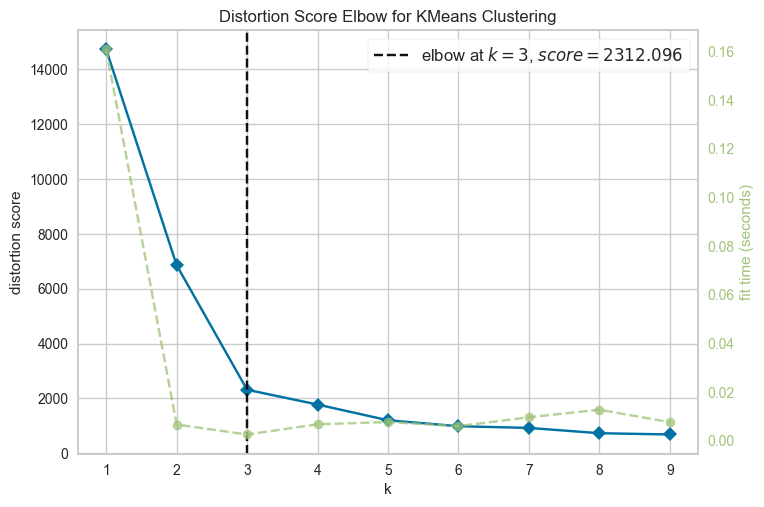

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_x_pca.to_pandas())
visualizer.show()

In [49]:
# Fit K-Means Clustering to the training data
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_x_pca)

In [50]:
# Labels
labels = kmeans.labels_

In [51]:
# Make a prediction on the trained K-Means algorithn
prediction_kmean = kmeans.predict(df_x_pca)

In [52]:
# Construct a DataFrame with the clusters
pl_df = pl.DataFrame({'clusters' : prediction_kmean})
testing_data_with_clusters = pl.concat([pl_df , df_x_pca], how="horizontal")

In [53]:
testing_data_with_clusters.head()

clusters,PCA1,PCA2
i32,f64,f64
1,0.505473,-1.470299
2,2.309651,2.924276
1,-0.789315,-2.319652
2,1.702031,2.996225
2,1.40948,0.15998


In [54]:
# Show the centers of clusters
kmeans.cluster_centers_

array([[-7.16119801,  1.39107396],
       [ 0.34550542, -2.35984555],
       [ 1.43333679,  1.73832583]])

##### Visualize the clusters

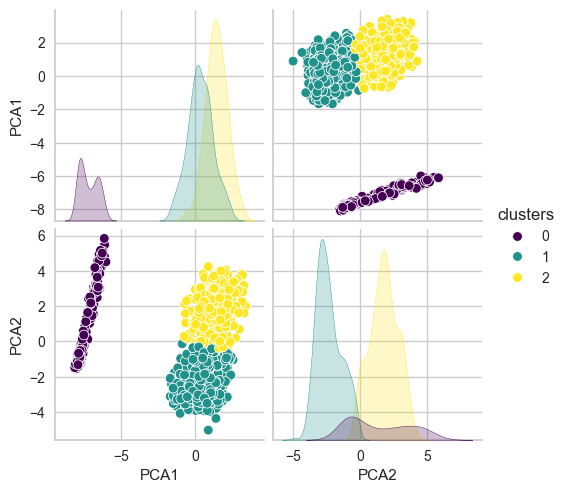

In [55]:
sns.pairplot(testing_data_with_clusters.to_pandas(), hue='clusters' , palette='viridis')
plt.show()

##### Silhouette Score

In [56]:
silh_score = silhouette_score(df_x_pca, labels)
print(silh_score)

0.6191581066900445
